In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [12]:
df_train = pd.read_csv(r'C:\Users\Linda Maisamari\Downloads\train 1.csv')
df_test = pd.read_csv(r'C:\Users\Linda Maisamari\Downloads\test 1.csv')

In [13]:
print(df_test.shape)
print(df_train.shape)

(1459, 80)
(1460, 81)


In [14]:
# combining the train and test set
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(2919, 81)

In [15]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,

In [16]:
df1 = df.copy()

In [17]:
df1.shape

(2919, 81)

Data Cleaning

In [18]:
# drop features with significant null values
df1.drop(['Alley','PoolQC', 'MiscFeature', 'Fence'], axis = 1, inplace = True)

In [19]:
# replacing Null values with NA - Not Available as directed using a function
def fill_null(df, columns):
    for column in columns:
        df[column].fillna('NA', inplace=True)

In [20]:
column = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'FireplaceQu','GarageQual','GarageCond',
         'GarageFinish', 'GarageType', 'Electrical','MasVnrType']
fill_null(df1, column)

In [21]:
# fill null values have low null values with mode
columns = ['MSZoning','Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional','SaleType']

def fill_mode(df, columns):
    for col in columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
fill_mode(df1, columns)

In [22]:
# fill num null values with mean
mean_columns = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                'BsmtFullBath', 'GarageCars', 'BsmtHalfBath', 'GarageArea']
def fill_mean(df, columns):
    for col in mean_columns:
        df[col].fillna(df[col].mean(), inplace=True)
        
fill_mean(df1, mean_columns)

In [23]:
null_counts = pd.DataFrame({'Column Name': df1.columns, 'Null Values Count': df1.isnull().sum()})
for index, row in null_counts.iterrows():
    print(f'{row["Column Name"]}: {row["Null Values Count"]}')

Id: 0
MSSubClass: 0
MSZoning: 0
LotFrontage: 0
LotArea: 0
Street: 0
LotShape: 0
LandContour: 0
Utilities: 0
LotConfig: 0
LandSlope: 0
Neighborhood: 0
Condition1: 0
Condition2: 0
BldgType: 0
HouseStyle: 0
OverallQual: 0
OverallCond: 0
YearBuilt: 0
YearRemodAdd: 0
RoofStyle: 0
RoofMatl: 0
Exterior1st: 0
Exterior2nd: 0
MasVnrType: 0
MasVnrArea: 0
ExterQual: 0
ExterCond: 0
Foundation: 0
BsmtQual: 0
BsmtCond: 0
BsmtExposure: 0
BsmtFinType1: 0
BsmtFinSF1: 0
BsmtFinType2: 0
BsmtFinSF2: 0
BsmtUnfSF: 0
TotalBsmtSF: 0
Heating: 0
HeatingQC: 0
CentralAir: 0
Electrical: 0
1stFlrSF: 0
2ndFlrSF: 0
LowQualFinSF: 0
GrLivArea: 0
BsmtFullBath: 0
BsmtHalfBath: 0
FullBath: 0
HalfBath: 0
BedroomAbvGr: 0
KitchenAbvGr: 0
KitchenQual: 0
TotRmsAbvGrd: 0
Functional: 0
Fireplaces: 0
FireplaceQu: 0
GarageType: 0
GarageYrBlt: 0
GarageFinish: 0
GarageCars: 0
GarageArea: 0
GarageQual: 0
GarageCond: 0
PavedDrive: 0
WoodDeckSF: 0
OpenPorchSF: 0
EnclosedPorch: 0
3SsnPorch: 0
ScreenPorch: 0
PoolArea: 0
MiscVal: 0
MoSold:

In [24]:
#df_train['YrSold'] = df_train['YrSold'].astype('int')
df1['YrSold'] = pd.to_datetime(df1['YrSold'], format='%Y')
df1['YrSold'] = df1['YrSold'].dt.year

In [25]:
df1['YearBuilt'].value_counts()

2005    142
2006    138
2007    109
2004     99
2003     88
       ... 
1896      1
1902      1
1913      1
1879      1
1904      1
Name: YearBuilt, Length: 118, dtype: int64

Exoloratory Data Analysis

In [26]:
# performing EDA using sweetviz 
#import sweetviz as sv
#report = sv.analyze(df1, target_feat="SalePrice")
#report.show_html("single_dataset_report.html")

<Figure size 1000x1000 with 0 Axes>

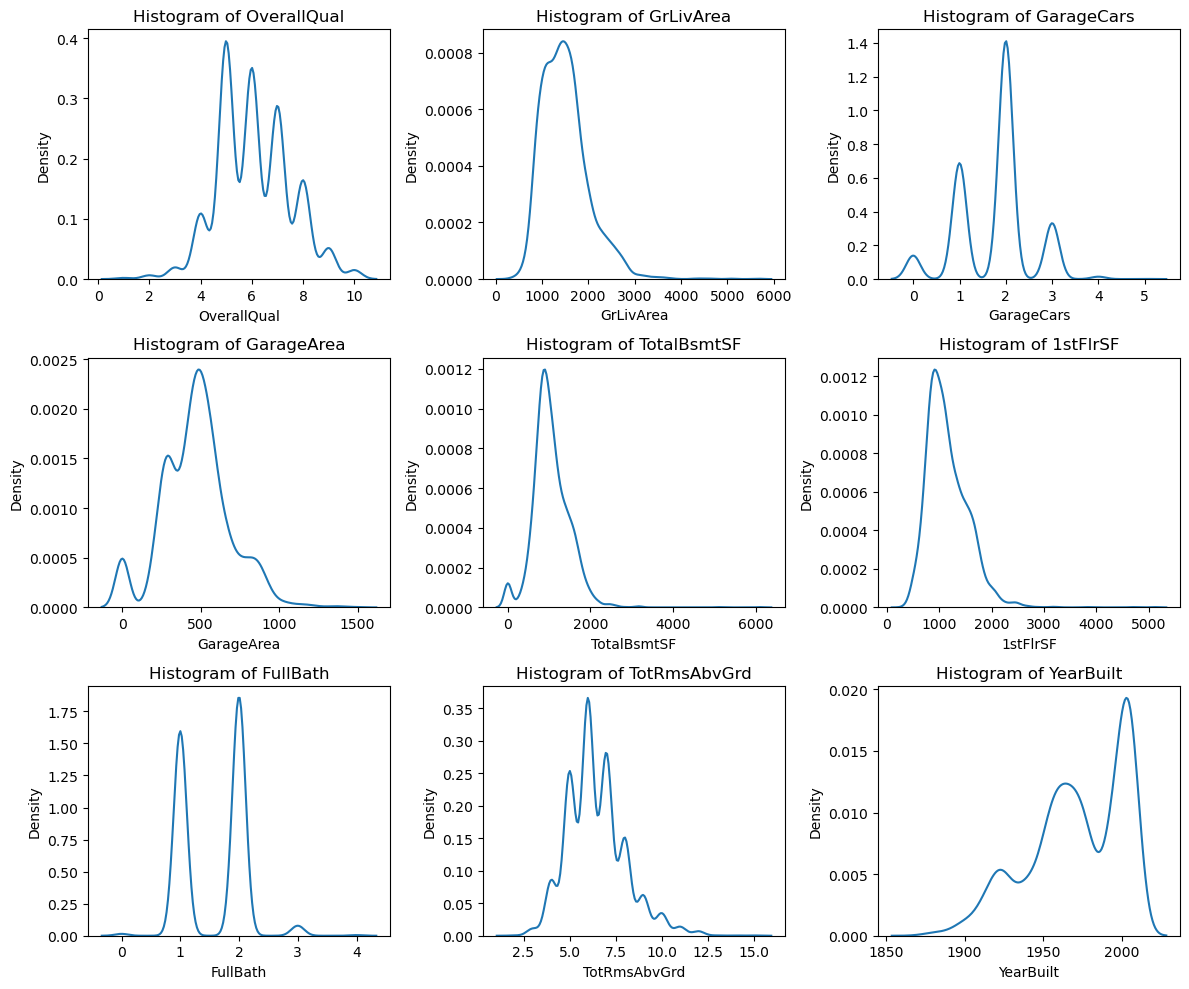

In [27]:
numerical_variables = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
plt.figure(figsize = (10,10))
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i, var in enumerate(numerical_variables):
    row, col = i // 3, i % 3  # Calculate row and column positions
    sns.distplot(df1[var], hist= False, ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {var}')
    axes[row, col].set_xlabel(var)
plt.tight_layout()
plt.show()

In [28]:
df1.HouseStyle.value_counts()

1Story    1471
2Story     872
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64

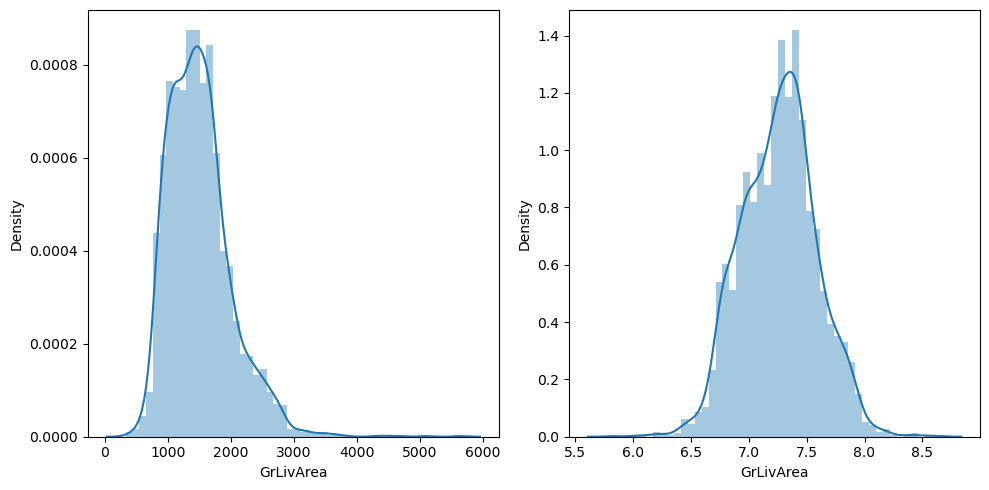

In [29]:
fig, ax = plt.subplots(1,2, figsize = [10,5])
sns.distplot(df1.GrLivArea, ax = ax[0])
sns.distplot(np.log(df1.GrLivArea), ax = ax[1]) 
plt.tight_layout()


df1.GrLivArea = np.log(df1.GrLivArea) #normalizing GrLivArea using log transformation

In [30]:
# split dataset into training and testing set 
train = df1[0:1460]
test_set = df1[1460:].drop(columns = ['SalePrice'])
test_set

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,6.797940,0.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961.000000,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,7.192182,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958.000000,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,7.395722,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000000,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,7.380256,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000000,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,7.154615,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1992.000000,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,6.995766,0.0,0.0,1,1,3,1,TA,5,Typ,0,NA,NA,1978.113406,NA,0.0,0.0,NA,NA,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,6.995766,0.0,0.0,1,1,3,1,TA,6,Typ,0,NA,CarPort,1970.000000,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,7.109879,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.000000,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,6.877296,0.0,

In [31]:
df1['SalePrice'][0:1460]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

In [32]:
# using the mutual info regression to see important features 
def make_mi(X, y):
    X = X.copy()
    for colname in X.select_dtypes(['object', 'category']):
        X[colname], _ = X[colname].factorize()
    mi_scores = mutual_info_regression(X,y, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = 'Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = df1[0:1460]
y = X.pop('SalePrice')

best_features = make_mi(X,y)
best_features

OverallQual     0.563819
Neighborhood    0.494378
GrLivArea       0.493804
TotalBsmtSF     0.370038
YearBuilt       0.369242
                  ...   
Utilities       0.000000
PoolArea        0.000000
3SsnPorch       0.000000
BsmtFinSF2      0.000000
Id              0.000000
Name: Scores, Length: 76, dtype: float64

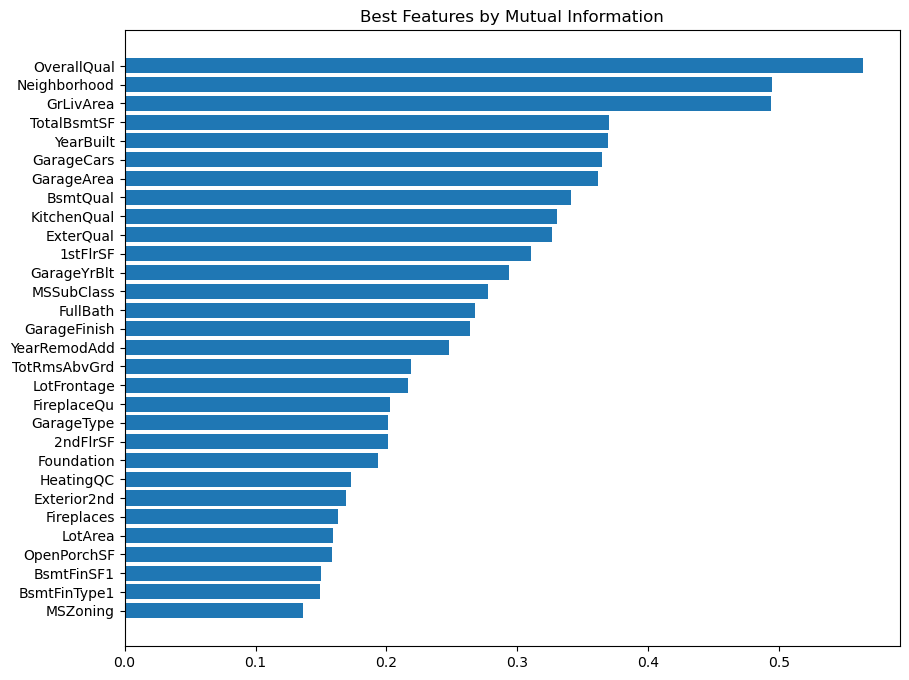

In [33]:
# Train model with the top 30 best features
top_30 = best_features.head(30).sort_values(ascending = True)
plt.figure(figsize = (10,8))
plt.barh(top_30.index, top_30.values)
plt.title('Best Features by Mutual Information')
plt.show()

In [34]:
best_features.index[0:30]

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt',
       'GarageCars', 'GarageArea', 'BsmtQual', 'KitchenQual', 'ExterQual',
       '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'FullBath', 'GarageFinish',
       'YearRemodAdd', 'TotRmsAbvGrd', 'LotFrontage', 'FireplaceQu',
       'GarageType', '2ndFlrSF', 'Foundation', 'HeatingQC', 'Exterior2nd',
       'Fireplaces', 'LotArea', 'OpenPorchSF', 'BsmtFinSF1', 'BsmtFinType1',
       'MSZoning'],
      dtype='object')

Feature Encoding

In [35]:
train_set = pd.concat([df1[best_features.index[0:30]], df1['Id']], axis =1)
train_set

,OverallQual,Neighborhood,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,BsmtQual,KitchenQual,ExterQual,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,GarageFinish,YearRemodAdd,TotRmsAbvGrd,LotFrontage,FireplaceQu,GarageType,2ndFlrSF,Foundation,HeatingQC,Exterior2nd,Fireplaces,LotArea,OpenPorchSF,BsmtFinSF1,BsmtFinType1,MSZoning,Id
0,7,CollgCr,7.444249,856.0,2003,2.0,548.0,Gd,Gd,Gd,856,2003.000000,60,2,RFn,2003,8,65.0,NA,Attchd,854,PConc,Ex,VinylSd,0,8450,61,706.0,GLQ,RL,1
1,6,Veenker,7.140453,1262.0,1976,2.0,460.0,Gd,TA,TA,1262,1976.000000,20,2,RFn,1976,6,80.0,TA,Attchd,0,CBlock,Ex,MetalSd,1,9600,0,978.0,ALQ,RL,2
2,7,CollgCr,7.487734,920.0,2001,2.0,608.0,Gd,Gd,Gd,920,2001.000000,60,2,RFn,2002,6,68.0,TA,Attchd,866,PConc,Ex,VinylSd,1,11250,42,486.0,GLQ,RL,3
3,7,Crawfor,7.448334,756.0,1915,3.0,642.0,TA,Gd,TA,961,1998.000000,70,1,Unf,1970,7,60.0,Gd,Detchd,756,BrkTil,Gd,Wd Shng,1,9550,35,216.0,ALQ,RL,4
4,8,NoRidge,7.695303,1145.0,2000,3.0,836.0,Gd,Gd,Gd,1145,2000.000000,60,2,RFn,2000,9,84.0,TA,Attchd,1053,PConc,Ex,VinylSd,1,14260,84,655.0,GLQ,RL,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,MeadowV,6.995766,546.0,1970,0.0,0.0,TA,TA,TA,546,1978.113406,160,1,NA,1970,5,21.0,NA,NA,546,CBlock,Gd,CmentBd,0,1936,0,0.0,Unf,RM,2915
1455,4,MeadowV,6.995766,546.0,1970,1.0,286.0,TA,TA,TA,546,1970.000000,160,1,Unf,1970,6,21.0,NA,CarPort,546,CBlock,TA,CmentBd,0,1894,24,252.0,Rec,RM,2916
1456,5,Mitchel,7.109879,1224.0,1960,2.0,576.0,TA,TA,TA,1224,1960.000000,20,1,Unf,1996,7,160.0,TA,Detchd,0,CBlock,Ex,VinylSd,1,20000,0,1224.0,ALQ,RL,2917
1457,5,Mitchel,6.877296,912.0,1992,0.0,0.0,Gd,TA,TA,970,1978.113406,85,1,NA,1992,6,62.0,NA,NA,0,PConc,TA,Wd Shng,0,10441,32,337.0,GLQ,RL,2918


In [36]:
train_set.select_dtypes('object').nunique().index

Index(['Neighborhood', 'BsmtQual', 'KitchenQual', 'ExterQual', 'GarageFinish',
       'FireplaceQu', 'GarageType', 'Foundation', 'HeatingQC', 'Exterior2nd',
       'BsmtFinType1', 'MSZoning'],
      dtype='object')

In [37]:
train_set['BsmtFinType1'].value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
NA      79
Name: BsmtFinType1, dtype: int64

In [38]:
train_set.select_dtypes(['int', 'float'])

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,YearRemodAdd,TotRmsAbvGrd,LotFrontage,2ndFlrSF,Fireplaces,LotArea,OpenPorchSF,BsmtFinSF1,Id
0,7,7.444249,856.0,2003,2.0,548.0,856,2003.000000,60,2,2003,8,65.0,854,0,8450,61,706.0,1
1,6,7.140453,1262.0,1976,2.0,460.0,1262,1976.000000,20,2,1976,6,80.0,0,1,9600,0,978.0,2
2,7,7.487734,920.0,2001,2.0,608.0,920,2001.000000,60,2,2002,6,68.0,866,1,11250,42,486.0,3
3,7,7.448334,756.0,1915,3.0,642.0,961,1998.000000,70,1,1970,7,60.0,756,1,9550,35,216.0,4
4,8,7.695303,1145.0,2000,3.0,836.0,1145,2000.000000,60,2,2000,9,84.0,1053,1,14260,84,655.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,6.995766,546.0,1970,0.0,0.0,546,1978.113406,160,1,1970,5,21.0,546,0,1936,0,0.0,2915
1455,4,6.995766,546.0,1970,1.0,286.0,546,1970.000000,160,1,1970,6,21.0,546,0,1894,24,252.0,2916
1456,5,7.109879,1224.0,1960,2.0,576.0,1224,1960.000000,20,1,1996,7,160.0,0,1,20000,0,1224.0,2917
1457,5,6.877296,912.0,1992,0.0,0.0,970,1978.113406,85,1,1992,6,62.0,0,0,10441,32,337.0,2918


In [39]:
# use label encoding to encode ordinal features 
label_encoder = LabelEncoder()
columns = ['ExterQual', 'HeatingQC', 'BsmtQual', 'KitchenQual','GarageFinish', 'FireplaceQu', ]
for column in columns:
    train_set[column] = label_encoder.fit_transform(train_set[column])

In [40]:
# check to see cardinality of these features
train_set.select_dtypes('object').nunique()

Neighborhood    25
GarageType       7
Foundation       6
Exterior2nd     16
BsmtFinType1     7
MSZoning         5
dtype: int64

In [41]:
train_set.BsmtFinType1.value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
NA      79
Name: BsmtFinType1, dtype: int64

In [42]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,7.444249,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,7.140453,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,7.487734,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,7.448334,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,7.695303,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953,694,0,7.406711,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000.0
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073,0,0,7.636752,1.0,0.0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000.0
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,GasA,Ex,Y,SBrkr,1188,1152,0,7.757906,0.0,0.0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1.0,252.0,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500.0
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49.0,Rec,1029.0,0.0,1078.0,GasA

In [43]:
# use mean target encoding to encode high cardinality features: Neighborhood and Exterior2nd 
cols = ['Neighborhood', 'Exterior2nd'] 
target = ['GrLivArea']

for col in cols:
    te = TargetEncoder()
    train_set[col + "_encoded"] = te.fit_transform(train_set[col], train_set[target])

In [44]:
train_set

,OverallQual,Neighborhood,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,BsmtQual,KitchenQual,ExterQual,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,GarageFinish,YearRemodAdd,TotRmsAbvGrd,LotFrontage,FireplaceQu,GarageType,2ndFlrSF,Foundation,HeatingQC,Exterior2nd,Fireplaces,LotArea,OpenPorchSF,BsmtFinSF1,BsmtFinType1,MSZoning,Id,Neighborhood_encoded,Exterior2nd_encoded
0,7,CollgCr,7.444249,856.0,2003,2.0,548.0,2,2,2,856,2003.000000,60,2,2,2003,8,65.0,3,Attchd,854,PConc,0,VinylSd,0,8450,61,706.0,GLQ,RL,1,7.270628,7.351266
1,6,Veenker,7.140453,1262.0,1976,2.0,460.0,2,3,3,1262,1976.000000,20,2,2,1976,6,80.0,5,Attchd,0,CBlock,0,MetalSd,1,9600,0,978.0,ALQ,RL,2,7.385661,7.176302
2,7,CollgCr,7.487734,920.0,2001,2.0,608.0,2,2,2,920,2001.000000,60,2,2,2002,6,68.0,5,Attchd,866,PConc,0,VinylSd,1,11250,42,486.0,GLQ,RL,3,7.270628,7.351266
3,7,Crawfor,7.448334,756.0,1915,3.0,642.0,4,2,3,961,1998.000000,70,1,3,1970,7,60.0,2,Detchd,756,BrkTil,2,Wd Shng,1,9550,35,216.0,ALQ,RL,4,7.417233,7.193897
4,8,NoRidge,7.695303,1145.0,2000,3.0,836.0,2,2,2,1145,2000.000000,60,2,2,2000,9,84.0,5,Attchd,1053,PConc,0,VinylSd,1,14260,84,655.0,GLQ,RL,5,7.794785,7.351266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,MeadowV,6.995766,546.0,1970,0.0,0.0,4,3,3,546,1978.113406,160,1,1,1970,5,21.0,3,NA,546,CBlock,2,CmentBd,0,1936,0,0.0,Unf,RM,2915,6.981707,7.342983
1455,4,MeadowV,6.995766,546.0,1970,1.0,286.0,4,3,3,546,1970.000000,160,1,3,1970,6,21.0,3,CarPort,546,CBlock,4,CmentBd,0,1894,24,252.0,Rec,RM,2916,6.981707,7.342983
1456,5,Mitchel,7.109879,1224.0,1960,2.0,576.0,4,3,3,1224,1960.000000,20,1,3,1996,7,160.0,5,Detchd,0,CBlock,0,VinylSd,1,20000,0,1224.0,ALQ,RL,2917,7.150372,7.351266
1457,5,Mitchel,6.877296,912.0,1992,0.0,0.0,2,3,3,970,1978.113406,85,1,1,1992,6,62.0,3,NA,0,PConc,4,Wd Shng,0,10441,32,337.0,GLQ,RL,2918,7.150372,7.193897


In [45]:
# use one hot encoding for 'GarageType', 'Foundation', 'BsmtFinType1', 'MSZoning'
columns = ['GarageType', 'Foundation', 'BsmtFinType1', 'MSZoning']
encoded_columns = []

for col in columns:
    encoded_col = pd.get_dummies(train_set[col], prefix=col)
    encoded_columns.append(encoded_col)

    
train_set = pd.concat([train_set] + encoded_columns, axis=1)

In [46]:
train_set

,OverallQual,Neighborhood,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,BsmtQual,KitchenQual,ExterQual,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,GarageFinish,YearRemodAdd,TotRmsAbvGrd,LotFrontage,FireplaceQu,GarageType,2ndFlrSF,Foundation,HeatingQC,Exterior2nd,Fireplaces,LotArea,OpenPorchSF,BsmtFinSF1,BsmtFinType1,MSZoning,Id,Neighborhood_encoded,Exterior2nd_encoded,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,7,CollgCr,7.444249,856.0,2003,2.0,548.0,2,2,2,856,2003.000000,60,2,2,2003,8,65.0,3,Attchd,854,PConc,0,VinylSd,0,8450,61,706.0,GLQ,RL,1,7.270628,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,6,Veenker,7.140453,1262.0,1976,2.0,460.0,2,3,3,1262,1976.000000,20,2,2,1976,6,80.0,5,Attchd,0,CBlock,0,MetalSd,1,9600,0,978.0,ALQ,RL,2,7.385661,7.176302,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,7,CollgCr,7.487734,920.0,2001,2.0,608.0,2,2,2,920,2001.000000,60,2,2,2002,6,68.0,5,Attchd,866,PConc,0,VinylSd,1,11250,42,486.0,GLQ,RL,3,7.270628,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,7,Crawfor,7.448334,756.0,1915,3.0,642.0,4,2,3,961,1998.000000,70,1,3,1970,7,60.0,2,Detchd,756,BrkTil,2,Wd Shng,1,9550,35,216.0,ALQ,RL,4,7.417233,7.193897,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,8,NoRidge,7.695303,1145.0,2000,3.0,836.0,2,2,2,1145,2000.000000,60,2,2,2000,9,84.0,5,Attchd,1053,PConc,0,VinylSd,1,14260,84,655.0,GLQ,RL,5,7.794785,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,MeadowV,6.995766,546.0,1970,0.0,0.0,4,3,3,546,1978.113406,160,1,1,1970,5,21.0,3,NA,546,CBlock,2,CmentBd,0,1936,0,0.0,Unf,RM,2915,6.981707,7.342983,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1455,4,MeadowV,6.995766,546.0,1970,1.0,286.0,4,3,3,546,1970.000000,160,1,3,1970,6,21.0,3,CarPort,546,CBlock,4,CmentBd,0,1894,24,252.0,Rec,RM,2916,6.981707,7.342983,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1456,5,Mitchel,7.109879,1224.0,1960,2.0,576.0,4,3,3,1224,1960.000000,20,1,3,1996,7,160.0,5,Detchd,0,CBlock,0,VinylSd,1,20000,0,1224.0,ALQ,RL,2917,7.150372,7.351266,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1457,5,Mitchel,6.877296,912.0,1992,0.0,0.0,2,3,3,970,1978.113406,85,1,1,1992,6,62.0,3,NA,0,PConc,4,Wd Shng,0,10441,32,337.0,GLQ,RL,2918,7.150372,7.193897,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [47]:
columns_to_replace = ['GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 
'GarageType_CarPort','GarageType_Detchd', 'GarageType_NA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 
'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 
'BsmtFinType1_LwQ', 'BsmtFinType1_NA', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'MSZoning_C (all)', 'MSZoning_FV', 
'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']

for col in columns_to_replace:
    train_set[col].replace({'True': 1, 'False': 0}, inplace=True)

In [48]:
columns_to_replace = ['GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 
'GarageType_CarPort','GarageType_Detchd', 'GarageType_NA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 
'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 
'BsmtFinType1_LwQ', 'BsmtFinType1_NA', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'MSZoning_C (all)', 'MSZoning_FV', 
'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']

for col in columns_to_replace:
    train_set[col] = train_set[col].astype('int')

In [49]:
train_set.dtypes

OverallQual               int64
Neighborhood             object
GrLivArea               float64
TotalBsmtSF             float64
YearBuilt                 int64
GarageCars              float64
GarageArea              float64
BsmtQual                  int32
KitchenQual               int32
ExterQual                 int32
1stFlrSF                  int64
GarageYrBlt             float64
MSSubClass                int64
FullBath                  int64
GarageFinish              int32
YearRemodAdd              int64
TotRmsAbvGrd              int64
LotFrontage             float64
FireplaceQu               int32
GarageType               object
2ndFlrSF                  int64
Foundation               object
HeatingQC                 int32
Exterior2nd              object
Fireplaces                int64
LotArea                   int64
OpenPorchSF               int64
BsmtFinSF1              float64
BsmtFinType1             object
MSZoning                 object
Id                        int64
Neighbor

In [50]:
train_set.drop(['Neighborhood', 'GarageType', 'Foundation', 'Exterior2nd',
                'BsmtFinType1', 'MSZoning'], axis = 1, inplace = True)

In [51]:
train_set.select_dtypes('object').nunique()

Series([], dtype: float64)

In [52]:
train_set

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,BsmtQual,KitchenQual,ExterQual,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,GarageFinish,YearRemodAdd,TotRmsAbvGrd,LotFrontage,FireplaceQu,2ndFlrSF,HeatingQC,Fireplaces,LotArea,OpenPorchSF,BsmtFinSF1,Id,Neighborhood_encoded,Exterior2nd_encoded,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,7,7.444249,856.0,2003,2.0,548.0,2,2,2,856,2003.000000,60,2,2,2003,8,65.0,3,854,0,0,8450,61,706.0,1,7.270628,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,6,7.140453,1262.0,1976,2.0,460.0,2,3,3,1262,1976.000000,20,2,2,1976,6,80.0,5,0,0,1,9600,0,978.0,2,7.385661,7.176302,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,7,7.487734,920.0,2001,2.0,608.0,2,2,2,920,2001.000000,60,2,2,2002,6,68.0,5,866,0,1,11250,42,486.0,3,7.270628,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,7,7.448334,756.0,1915,3.0,642.0,4,2,3,961,1998.000000,70,1,3,1970,7,60.0,2,756,2,1,9550,35,216.0,4,7.417233,7.193897,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,8,7.695303,1145.0,2000,3.0,836.0,2,2,2,1145,2000.000000,60,2,2,2000,9,84.0,5,1053,0,1,14260,84,655.0,5,7.794785,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,6.995766,546.0,1970,0.0,0.0,4,3,3,546,1978.113406,160,1,1,1970,5,21.0,3,546,2,0,1936,0,0.0,2915,6.981707,7.342983,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1455,4,6.995766,546.0,1970,1.0,286.0,4,3,3,546,1970.000000,160,1,3,1970,6,21.0,3,546,4,0,1894,24,252.0,2916,6.981707,7.342983,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1456,5,7.109879,1224.0,1960,2.0,576.0,4,3,3,1224,1960.000000,20,1,3,1996,7,160.0,5,0,0,1,20000,0,1224.0,2917,7.150372,7.351266,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1457,5,6.877296,912.0,1992,0.0,0.0,2,3,3,970,1978.113406,85,1,1,1992,6,62.0,3,0,4,0,10441,32,337.0,2918,7.150372,7.193897,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [53]:
# split into train and test data
m_train = train_set[0:1460]
m_test = train_set[1460:]
y_test = df1['SalePrice'][0:1459]

In [54]:
m_test

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,BsmtQual,KitchenQual,ExterQual,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,GarageFinish,YearRemodAdd,TotRmsAbvGrd,LotFrontage,FireplaceQu,2ndFlrSF,HeatingQC,Fireplaces,LotArea,OpenPorchSF,BsmtFinSF1,Id,Neighborhood_encoded,Exterior2nd_encoded,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,5,6.797940,882.0,1961,1.0,730.0,4,3,3,896,1961.000000,20,1,3,1961,5,80.0,3,0,4,0,11622,0,468.0,1461,7.125811,7.351266,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,6,7.192182,1329.0,1958,1.0,312.0,4,2,3,1329,1958.000000,20,1,3,1958,6,81.0,3,0,4,0,14267,36,923.0,1462,7.125811,7.203757,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,5,7.395722,928.0,1997,2.0,482.0,2,3,3,928,1997.000000,60,2,0,1998,6,74.0,5,701,2,1,13830,34,791.0,1463,7.375145,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,6,7.380256,926.0,1998,2.0,470.0,4,2,3,926,1998.000000,60,2,0,1998,7,78.0,2,678,0,1,9978,36,602.0,1464,7.375145,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,8,7.154615,1280.0,1992,2.0,506.0,2,2,2,1280,1992.000000,120,2,2,1992,5,43.0,3,0,0,0,5005,82,263.0,1465,7.519871,7.191329,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,6.995766,546.0,1970,0.0,0.0,4,3,3,546,1978.113406,160,1,1,1970,5,21.0,3,546,2,0,1936,0,0.0,2915,6.981707,7.342983,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1455,4,6.995766,546.0,1970,1.0,286.0,4,3,3,546,1970.000000,160,1,3,1970,6,21.0,3,546,4,0,1894,24,252.0,2916,6.981707,7.342983,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1456,5,7.109879,1224.0,1960,2.0,576.0,4,3,3,1224,1960.000000,20,1,3,1996,7,160.0,5,0,0,1,20000,0,1224.0,2917,7.150372,7.351266,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1457,5,6.877296,912.0,1992,0.0,0.0,2,3,3,970,1978.113406,85,1,1,1992,6,62.0,3,0,4,0,10441,32,337.0,2918,7.150372,7.193897,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Model training

In [55]:
# def a function to validate model
def score_dataset(X, y, model=XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 4, n_estimators = 100, random_state = 1)):
    score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_log_error",)
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [56]:
X = m_train
y_train = df1['SalePrice'][0:1460]
score_dataset(X, y)

0.13618667614805188

In [57]:
model = XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 4, n_estimators = 100, random_state = 1)
model.fit(X, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [58]:
X_pred = model.predict(m_train)
X_pred

array([207368.77, 174065.95, 209521.52, ..., 257601.77, 123999.07,
       141989.98], dtype=float32)

In [59]:
y_pred = model.predict(m_test)
y_pred

array([127276.69, 146776.52, 184938.44, ..., 162170.48, 118269.64,
       222017.66], dtype=float32)

In [60]:
rmse = mean_squared_error(y_train, X_pred, squared=False)
rmse

13389.670211264889

In [61]:
# using grid search CV to find the best parameters for the XGB regressor model
''' param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5],         
    'learning_rate': [0.01, 0.1, 0.2],  
    'colsample_bytree': [0.5, 0.75, 1.0], 
    'n_jobs '
}

xgb = XGBRegressor(random_state=0)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X, y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = np.sqrt(-1 * grid_search.best_score_)

print("Best Parameters:", best_params)
print("Best RMSE:", best_score) '''

' param_grid = {\n    \'n_estimators\': [100, 200, 300],  \n    \'max_depth\': [3, 4, 5],         \n    \'learning_rate\': [0.01, 0.1, 0.2],  \n    \'colsample_bytree\': [0.5, 0.75, 1.0], \n    \'n_jobs \'\n}\n\nxgb = XGBRegressor(random_state=0)\ngrid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\', verbose=2)\n\ngrid_search.fit(X, y)\n\n# Get the best parameters and best score\nbest_params = grid_search.best_params_\nbest_score = np.sqrt(-1 * grid_search.best_score_)\n\nprint("Best Parameters:", best_params)\nprint("Best RMSE:", best_score) '

Feature Engineering

In [62]:
# since housestyle have a strong relationship to 2ndFlrSF. The mean is used to encode for the house style
mean_2ndFlrSF_by_HouseStyle = train.groupby('HouseStyle')['2ndFlrSF'].mean()
mean_2ndFlrSF_by_HouseStyle
train_set['HouseStyle_Mean_2ndFlrSF'] = train['HouseStyle'].map(mean_2ndFlrSF_by_HouseStyle)

In [63]:
train_set

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,BsmtQual,KitchenQual,ExterQual,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,GarageFinish,YearRemodAdd,TotRmsAbvGrd,LotFrontage,FireplaceQu,2ndFlrSF,HeatingQC,Fireplaces,LotArea,OpenPorchSF,BsmtFinSF1,Id,Neighborhood_encoded,Exterior2nd_encoded,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,HouseStyle_Mean_2ndFlrSF
0,7,7.444249,856.0,2003,2.0,548.0,2,2,2,856,2003.000000,60,2,2,2003,8,65.0,3,854,0,0,8450,61,706.0,1,7.270628,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,880.260674
1,6,7.140453,1262.0,1976,2.0,460.0,2,3,3,1262,1976.000000,20,2,2,1976,6,80.0,5,0,0,1,9600,0,978.0,2,7.385661,7.176302,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.907713
2,7,7.487734,920.0,2001,2.0,608.0,2,2,2,920,2001.000000,60,2,2,2002,6,68.0,5,866,0,1,11250,42,486.0,3,7.270628,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,880.260674
3,7,7.448334,756.0,1915,3.0,642.0,4,2,3,961,1998.000000,70,1,3,1970,7,60.0,2,756,2,1,9550,35,216.0,4,7.417233,7.193897,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,880.260674
4,8,7.695303,1145.0,2000,3.0,836.0,2,2,2,1145,2000.000000,60,2,2,2000,9,84.0,5,1053,0,1,14260,84,655.0,5,7.794785,7.351266,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,880.260674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,6.995766,546.0,1970,0.0,0.0,4,3,3,546,1978.113406,160,1,1,1970,5,21.0,3,546,2,0,1936,0,0.0,2915,6.981707,7.342983,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.907713
1455,4,6.995766,546.0,1970,1.0,286.0,4,3,3,546,1970.000000,160,1,3,1970,6,21.0,3,546,4,0,1894,24,252.0,2916,6.981707,7.342983,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,880.260674
1456,5,7.109879,1224.0,1960,2.0,576.0,4,3,3,1224,1960.000000,20,1,3,1996,7,160.0,5,0,0,1,20000,0,1224.0,2917,7.150372,7.351266,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.907713
1457,5,6.877296,912.0,1992,0.0,0.0,2,3,3,970,1978.113406,85,1,1,1992,6,62.0,3,0,4,0,10441,32,337.0,2918,7.150372,7.193897,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,880.260674


In [64]:
train_set['HouseStyle_Mean_2ndFlrSF'].dtype

dtype('float64')

In [65]:
# using .greater than (.gt), we calculated sum of total porch types where True is 1 and false is 0
train_set["PorchTypes"] = train[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].gt(0.0).sum(axis = 1)

In [66]:
# using .transform : assigns GrLivarea median to all neighborhood respectively
train_set["MedNhbdArea"] = train.groupby('Neighborhood')['GrLivArea'].transform('median')

In [67]:
df_test.shape

(1459, 80)

In [68]:
y_pred.shape

(1459,)

In [69]:
y_pred = pd.DataFrame({'SalePrice': y_pred})

In [70]:
submission = pd.concat([m_test['Id'], y_pred], axis =1)

In [71]:
submission.to_csv('Final submission 4.csv', index = False)

In [72]:
X_pred = pd.DataFrame({'X_pred':X_pred})

In [73]:
df_train = df_train.join(X_pred)
df_train['X_pred'] = df_train['X_pred'].round().astype('int')
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,X_pred
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,207369
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,174066
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,209522
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,165124
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,277109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,173766
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,209346
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,257602
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalS

In [74]:
#df_train['YrSold'] = df_train['YrSold'].astype('int')
df_train['YrSold'] = pd.to_datetime(df_train['YrSold'], format='%Y')
df_train['YrSold'] = df_train['YrSold'].dt.year
df_train['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [76]:
# check correlation of the model and notice if it will have any effect on the target variable.
df_train['YrSold'].corr(df_train['SalePrice'])

-0.028922585168730343